In [ ]:
import os
os.chdir('..')

from optimizations.readout_mitigation.fem import Mitigator
from qiskit.quantum_info.analysis import hellinger_fidelity
from optimizations.readout_mitigation.fem.tools import npformat_to_statuscnt,downsample
from time import time
import pickle
import matplotlib.pyplot as plt
import logging
logging.getLogger('qiskit').setLevel(logging.ERROR)

We run a GHZ circuit on the QuaFu quantum computer and load its data. Then, we compare its fidelity with the ideal results without noise.

In [2]:
ghz_output = pickle.load(file=open('/home/zhanghanyu/JanusQ/dataset/ghz_error','rb'))

samples = 10000
un_fid = []
for i in range(len(ghz_output)):
    n_qubits = 6+i*2
    ghz_noisy = ghz_output[i]
    outout_ideal = {'1'*n_qubits:samples*0.5,'0'*n_qubits:samples*0.5}
    un_fid.append(hellinger_fidelity(ghz_noisy,outout_ideal))


**IBU (reduced = 3)**

To utilize the IBU method, measure the benchmark circuit on the QuaFu quantum computer and load its data. Then, we calibrate the results of the GHZ circuit using IBU method.

In [3]:
from baselines.readout_calibration.IBU.src.IBU import IBU
from baselines.readout_calibration.IBU.utils.qc_utils import *
from baselines.readout_calibration.IBU.utils.data_utils import *
matrices = pickle.load(file=open('/home/zhanghanyu/JanusQ/dataset/matrices_16.pickle','rb'))
t_ibu_new = []
ibu_fid = []
for i in range(len(ghz_output)):
    n_qubits = 6+i*2
    params = {
        "exp_name": "ghz",
        "method": "reduced",  
        "library": "jax",  
        "num_qubits": n_qubits,
        "max_iters": 1000,
        "tol": 1e-5,
        "use_log": False,  
        "verbose": True,
        "init": "unif",  
        "smoothing": 1e-8,
        "ham_dist": 3
    }

    matrices_ibu = matrices[:n_qubits]
    outout_ideal = {'1'*n_qubits:samples*0.5,'0'*n_qubits:samples*0.5}


    ibu_new = IBU(matrices_ibu, params)
    ghz_noisy = ghz_output[i]
    ibu_new.set_obs(dict(ghz_noisy))
    t_ibu_new_1 = time()
    ibu_new.initialize_guess()
    t_sol_new, max_iters_new, tracker_new = ibu_new.train(params["max_iters"], tol=params["tol"], soln=outout_ideal)
    t_ibu_new_2 = time()
    outout_ibu_new = ibu_new.guess_as_dict()

    t_ibu_new.append(t_ibu_new_2-t_ibu_new_1)
    ibu_fid.append(hellinger_fidelity(outout_ideal,outout_ibu_new).item())



2024-04-02 07:09:08.454323: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


Processing dictionary of counts...


Encoding expanded set of bitstrings as matrix: 100%|██████████| 64/64 [00:00<00:00, 519217.52it/s]


Initializing guess with uniform distribution over the expanded set of bitstrings...


IBU Iteration:   7%|▋         | 66/1000 [00:01<00:16, 56.60it/s]


Waiting for JAX to return control flow...
Processing dictionary of counts...


Encoding expanded set of bitstrings as matrix: 100%|██████████| 256/256 [00:00<00:00, 654720.62it/s]


Initializing guess with uniform distribution over the expanded set of bitstrings...


IBU Iteration:   4%|▍         | 38/1000 [00:00<00:10, 93.11it/s]


Waiting for JAX to return control flow...
Processing dictionary of counts...


Encoding expanded set of bitstrings as matrix: 100%|██████████| 875/875 [00:00<00:00, 611058.28it/s]


Initializing guess with uniform distribution over the expanded set of bitstrings...


IBU Iteration:   8%|▊         | 79/1000 [00:00<00:06, 148.80it/s]


Waiting for JAX to return control flow...
Processing dictionary of counts...


Encoding expanded set of bitstrings as matrix: 100%|██████████| 2058/2058 [00:00<00:00, 570740.39it/s]


Initializing guess with uniform distribution over the expanded set of bitstrings...


IBU Iteration:   9%|▉         | 93/1000 [00:01<00:10, 87.55it/s] 


Waiting for JAX to return control flow...
Processing dictionary of counts...


Encoding expanded set of bitstrings as matrix: 100%|██████████| 3796/3796 [00:00<00:00, 511076.88it/s]


Initializing guess with uniform distribution over the expanded set of bitstrings...


IBU Iteration:  12%|█▏        | 116/1000 [00:02<00:17, 49.85it/s]

Waiting for JAX to return control flow...


Processing dictionary of counts...


Encoding expanded set of bitstrings as matrix: 100%|██████████| 6329/6329 [00:00<00:00, 480962.26it/s]

Initializing guess with uniform distribution over the expanded set of bitstrings...



IBU Iteration:  10%|█         | 104/1000 [00:03<00:29, 30.53it/s]

Waiting for JAX to return control flow...


**QuFEM**

We measure the benchmark circuit required for QuFEM on the QuaFu quantum computer and load its data. Then, we calibrate the results of the GHZ circuit using QuFEM method.

In [4]:
t_qufem_new = []
qufem_fid = []
mitigator = pickle.load(file=open('/home/zhanghanyu/JanusQ/dataset/mitigator.pickle','rb'))
benchmark = pickle.load(file=open('/home/zhanghanyu/JanusQ/dataset/protocol_16.pickle','rb'))
miti = []
for i in range(len(ghz_output)):
    n_qubits = 6+i*2
    benchmark_circuits = downsample(benchmark,[i for i in range(n_qubits)])

    outout_ideal = {'1'*n_qubits:samples*0.5,'0'*n_qubits:samples*0.5}

    bstrs = []
    for key in benchmark_circuits.keys():
        bstrs.append(np.array(list(key), dtype=np.int8))

    protocol_statuscnts = []
    for value in benchmark_circuits.values():
        protocol_statuscnts.append(value)

    
    t_qufem_1_new = time()
    output_fem = mitigator[i].mitigate(ghz_output[i])
    t_qufem_2_new = time()
    output_fem = npformat_to_statuscnt(output_fem)

    t_qufem_new.append(t_qufem_2_new-t_qufem_1_new)
    qufem_fid.append(hellinger_fidelity(outout_ideal,output_fem))


**Fidelity Comparison**

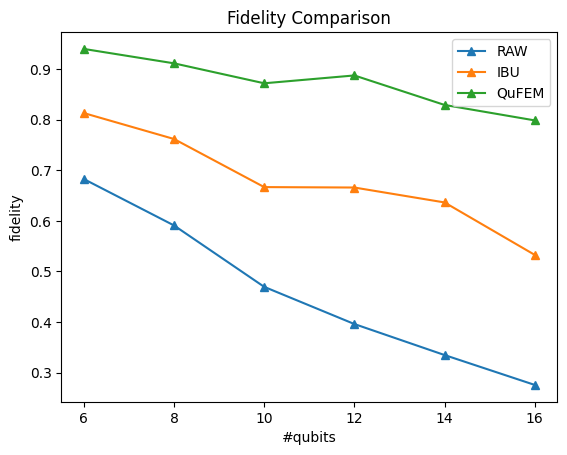

In [5]:
x = [6+i*2 for i in range(len(ghz_output))]

plt.plot(x, un_fid, label='RAW', marker='^', linestyle='-')
plt.plot(x, ibu_fid, label='IBU', marker='^', linestyle='-')
plt.plot(x, qufem_fid, label='QuFEM', marker='^', linestyle='-')
plt.xticks(x) 
plt.title('Fidelity Comparison')
plt.xlabel('#qubits')
plt.ylabel('fidelity')

plt.legend()

plt.show()


**Time Comparison**

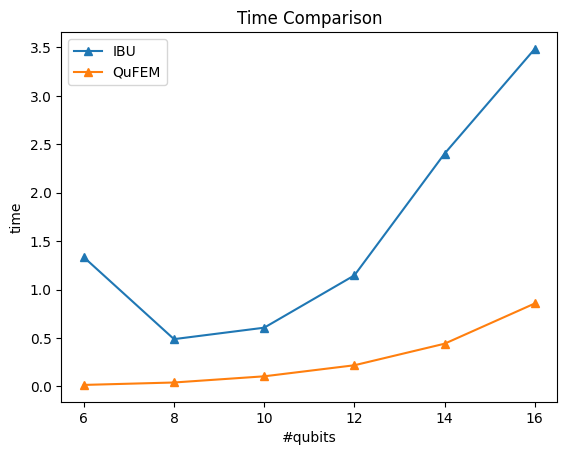

In [6]:
x = [6+i*2 for i in range(len(ghz_output))]

plt.plot(x, t_ibu_new, label='IBU', marker='^', linestyle='-')
plt.plot(x, t_qufem_new, label='QuFEM', marker='^', linestyle='-')
plt.xticks(x) 
plt.title('Time Comparison')
plt.xlabel('#qubits')
plt.ylabel('time')

plt.legend()

plt.show()

**Results**

We propose QuFEM to calibrate the measurement error. First, we formulate the calibration as a series of tensor-product operations involving sub-noise matrices, where the matrix is iteratively updated with the probability distribution. Then, we introduce how to generate the benchmarking circuits with low time complexity for characterization. Experiments demonstrate that Qufem has higher fidelity and faster calibration speed compared to IBU (reduced = 3).

**References**



<div><a name="R1"></a>
[1] Philip Krantz, Morten Kjaergaard, et al. A quantum engineer’s guide to
superconducting qubits[J]. Applied Physics Reviews, 2019.
</div>


<div><a name="R2"></a>
[2] Sergey Bravyi, Sarah Sheldon, et al. Mitigating measurement errors in multiqubit experi-
ments[J]. Physical Review A, 2021.
</div>

<div><a name="R3"></a>
[2] P. Rebentrost, M. Mohseni, et al. Quantum support vector
machine for big feature and big data classification[J]. Physical Review
Letters, 2013.
</div>


<div><a name="R4"></a>
[4] Satzinger K J, Liu Y J, Smith A, et al. Realizing topologically ordered states on a quantum processor[J]. Science, 2021.
</div>

<div><a name="R5"></a>
[5] Nation P D, Kang H, Sundaresan N, et al. Scalable mitigation of measurement errors on quantum computers[J]. PRX Quantum, 2021.
</div>

<div><a name="R6"></a>
[6] Bravyi S, Sheldon S, Kandala A, et al. Mitigating measurement errors in multiqubit experiments[J]. Physical Review A, 2021.
</div>

<div><a name="R7"></a>
[7]  Beijing Academy of Quantum Information Sciences. Quafu quantum cloud computing platform. https://quafu.baqis.ac.cn/
</div>



